# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 29, 11:59PM

### Name: Harsh Sanjay Agrawal


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
from keras.datasets import cifar10
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

170508288/170498071 [==============================] - 4s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    result = np.zeros((y.shape[0],10))
    for i in range(len(y)):
        result[i][y[i]] = 1
    return result

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
myarr = np.arange(50000)
np.random.shuffle(myarr)
train_index = myarr[0:40000]
validation_index = myarr[40000:50000]


x_tr = x_train[train_index, :]
y_tr = y_train_vec[train_index, :]
x_val = x_train[validation_index, :]
y_val = y_train_vec[validation_index, :]


print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [4]:
"""
Colvolution 3@32x32
max-pool 32@30x30
convolution 32@15x15
max-pool 64@12x12
dense 64@6x6
1x256
1x10

Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax
"""

# Build the model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='valid', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (4, 4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 12, 12, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [5]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.3,
    zoom_range=0.1,
    horizontal_flip=True)

train_datagen.fit(x_tr)
train_generator = train_datagen.flow(x_tr, y_tr, batch_size=64)
test_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=64)

learning_rate = 0.001 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [6]:
# Train the model and store model parameters/loss values
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 79s 124ms/step - loss: 3.3214 - acc: 0.1962 - val_loss: 2.1853 - val_acc: 0.2253
Epoch 2/10
625/625 [==============================] - 78s 125ms/step - loss: 1.7661 - acc: 0.3718 - val_loss: 1.5058 - val_acc: 0.4593
Epoch 3/10
625/625 [==============================] - 77s 123ms/step - loss: 1.5336 - acc: 0.4605 - val_loss: 1.4641 - val_acc: 0.4937
Epoch 4/10
625/625 [==============================] - 76s 121ms/step - loss: 1.4497 - acc: 0.4945 - val_loss: 1.3842 - val_acc: 0.5498
Epoch 5/10
625/625 [==============================] - 76s 122ms/step - loss: 1.4018 - acc: 0.5178 - val_loss: 1.3463 - val_acc: 0.5508
Epoch 6/10
625/625 [==============================] - 76s 122ms/step - loss: 1.3671 - acc: 0.5346 - val_loss: 1.3705 - val_acc: 0.5632
Epoch 7/10
625/625 [==============================] - 76s 122ms/step - loss: 1.3241 - acc: 0.5494 - val_loss: 1.1454 - val_acc: 0.6155
Epoch 8/10
625/625 [==============================] - 7

## 3. Plot the training and validation loss curve versus epochs. (5 points)

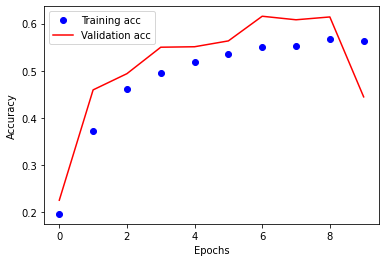

In [7]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
# # Evaluate your model performance (teloss_and_acc = model.evaluate(x_test, y_test_vec)
# loss_and_acc = model.evaluate(x_test, y_test_vec)
# print('loss = ' + str(loss_and_acc[0]))
# print('accuracy = ' + str(loss_and_acc[1]))

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [9]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
# Define model optimizer and loss function
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.3,
    zoom_range=0.1,
    horizontal_flip=True)

train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, y_train_vec, batch_size=64)
test_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=64)

learning_rate = 0.001 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [10]:
#<Train your model on the entire training set (50K samples)>
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
782/782 [==============================] - 97s 123ms/step - loss: 1.2921 - acc: 0.5664 - val_loss: 1.0877 - val_acc: 0.6229
Epoch 2/10
782/782 [==============================] - 102s 131ms/step - loss: 1.2922 - acc: 0.5702 - val_loss: 1.5931 - val_acc: 0.4850
Epoch 3/10
782/782 [==============================] - 97s 124ms/step - loss: 1.2514 - acc: 0.5772 - val_loss: 1.2061 - val_acc: 0.5896
Epoch 4/10
782/782 [==============================] - 95s 122ms/step - loss: 1.2365 - acc: 0.5836 - val_loss: 1.0314 - val_acc: 0.6435
Epoch 5/10
782/782 [==============================] - 95s 121ms/step - loss: 1.2471 - acc: 0.5796 - val_loss: 1.3169 - val_acc: 0.5719
Epoch 6/10
782/782 [==============================] - 95s 121ms/step - loss: 1.2377 - acc: 0.5857 - val_loss: 1.0715 - val_acc: 0.6288
Epoch 7/10
782/782 [==============================] - 95s 122ms/step - loss: 1.2357 - acc: 0.5834 - val_loss: 1.1955 - val_acc: 0.5960
Epoch 8/10
782/782 [==============================] - 

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [11]:
# Evaluate your model performance (teloss_and_acc = model.evaluate(x_test, y_test_vec)
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 5s 15ms/step - loss: 1.1347 - acc: 0.6091
loss = 1.134657621383667
accuracy = 0.6090999841690063


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


782/782 [==============================] - 337s 428ms/step - loss: 1.4250 - acc: 0.4942 - val_loss: 1.2150 - val_acc: 0.5962
Epoch 2/10
782/782 [==============================] - 335s 428ms/step - loss: 1.0523 - acc: 0.6245 - val_loss: 1.1628 - val_acc: 0.6068
Epoch 3/10
782/782 [==============================] - 332s 424ms/step - loss: 0.9224 - acc: 0.6736 - val_loss: 1.0152 - val_acc: 0.6716
Epoch 4/10
782/782 [==============================] - 334s 427ms/step - loss: 0.8590 - acc: 0.6981 - val_loss: 1.0083 - val_acc: 0.6823
Epoch 5/10
782/782 [==============================] - 339s 433ms/step - loss: 0.8098 - acc: 0.7152 - val_loss: 0.9229 - val_acc: 0.6953
Epoch 6/10
782/782 [==============================] - 343s 438ms/step - loss: 0.7623 - acc: 0.7344 - val_loss: 0.9793 - val_acc: 0.6989
Epoch 7/10
782/782 [==============================] - 343s 439ms/step - loss: 0.7384 - acc: 0.7435 - val_loss: 0.7070 - val_acc: 0.7526
Epoch 8/10
782/782 [==============================] - 339s 

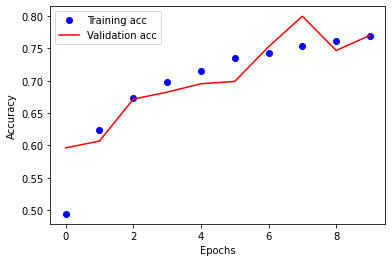

In [14]:
from keras.layers import BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

history = model.fit(train_generator, epochs=10, validation_data=test_generator)


loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


782/782 [==============================] - 451s 574ms/step - loss: 1.4239 - acc: 0.4922 - val_loss: 1.1306 - val_acc: 0.6021
Epoch 2/10
782/782 [==============================] - 447s 571ms/step - loss: 1.0104 - acc: 0.6428 - val_loss: 0.9050 - val_acc: 0.6802
Epoch 3/10
782/782 [==============================] - 447s 572ms/step - loss: 0.8702 - acc: 0.6948 - val_loss: 1.0529 - val_acc: 0.6468
Epoch 4/10
782/782 [==============================] - 445s 569ms/step - loss: 0.7818 - acc: 0.7265 - val_loss: 0.6800 - val_acc: 0.7651
Epoch 5/10
782/782 [==============================] - 449s 574ms/step - loss: 0.7320 - acc: 0.7451 - val_loss: 0.6378 - val_acc: 0.7797
Epoch 6/10
782/782 [==============================] - 446s 571ms/step - loss: 0.6830 - acc: 0.7652 - val_loss: 2.2084 - val_acc: 0.5078
Epoch 7/10
782/782 [==============================] - 448s 573ms/step - loss: 0.6569 - acc: 0.7755 - val_loss: 0.8436 - val_acc: 0.7407
Epoch 8/10
782/782 [==============================] - 449s 

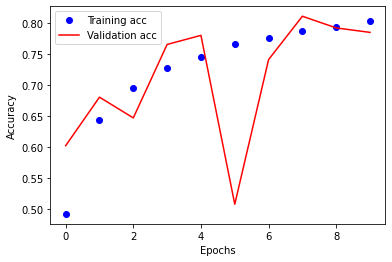

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

history = model.fit(train_generator, epochs=10, validation_data=test_generator)


loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()